In [2]:
library(circlize)
library(ComplexHeatmap)
library(data.table)

In [3]:
trans_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_CD4_NC_tophits_multianno/"
trans_files = paste0(trans_dir,list.files(trans_dir))
head(trans_files,2)

[1] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_CD4_NC_tophits_multianno/A1BG_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"
[2] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_CD4_NC_tophits_multianno/A2M_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"

In [4]:
gene_locs_file = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/GeneLocations.tsv"
gene_loc = fread(gene_locs_file)
head(gene_loc)

gene_name,gene_id,seqid,start,end,strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>
AL627309.1,ENSG00000237683,1,134901,139379,-
AL669831.1,ENSG00000269831,1,738532,739137,-
AL645608.2,ENSG00000269308,1,818043,819983,+
AL645608.1,ENSG00000268179,1,861264,866445,-
AL645728.1,ENSG00000215014,1,1510355,1511373,+
AL590822.2,ENSG00000269554,1,2121237,2123179,+


In [5]:
gene_files = list.files(paste0(trans_dir,"merged/"), pattern=".merged.txt")
length(gene_files)
head(gene_files,2)

[1] 12783

[1] "A1BG_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"
[2] "A2M_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"

In [6]:
genes = gsub("_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt", "", gene_files)
length(genes)
head(genes)

[1] 12783

[1] "A1BG"  "A2M"   "AAAS"  "AACS"  "AAED1" "AAGAB"

In [7]:
df_list = list()
for (i in 1:length(genes)){
    gene = genes[i]
    chrom = gene_loc[gene_loc$gene_name == gene,"seqid"]$seqid[1]
    gene_start = gene_loc[gene_loc$gene_name == gene,"start"]$start[1]
    gene_end = gene_loc[gene_loc$gene_name == gene,"end"]$end[1]
    file = paste0(trans_dir,"merged/",gene_files[i])
    df = as.data.frame(fread(file))
    if (nrow(df)==0){next}
    colnames(df)[(ncol(df)-2):ncol(df)] <- c("p.value","neg.log10.p.value","cis.trans")
    # filter to genome-wide significance
    df = df[df$p.value < 5e-8,]
    if (nrow(df)==0){next}
    # remove HLA region (https://www.ncbi.nlm.nih.gov/grc/human/regions/MHC?asm=GRCh37)
    df = df[!(df$Chr==6 & df$Start >= 28477797 & df$Start <= 33448354),]
    if (nrow(df)==0){next}
    colnames(df)[1:5] <- paste0("snp_",colnames(df)[1:5])
    df$gene_chr = chrom
    df$gene_start = gene_start
    df$gene_end = gene_end
    df$window_start = max(0,min(gene_start, gene_end)-2000000)
    df$window_end = max(gene_start, gene_end)+2000000
    df$gene = gene
    df_list[[gene]] = df
}
df_combine = rbindlist(df_list)

In [8]:
nrow(df_combine)
head(df_combine)

[1] 1186

snp_Chr,snp_Start,snp_End,snp_Ref,snp_Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,⋯,SiPhy_29way_logOdds,p.value,neg.log10.p.value,cis.trans,gene_chr,gene_start,gene_end,window_start,window_end,gene
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
19,16410530,16410530,C,T,intergenic,AP1M1;KLF2,dist=53816;dist=25107,NA,NA,⋯,NA,1.45986e-08,7.835689,potential_novel,19,58856544,58864865,56856544,60864865,A1BG
4,89150178,89150178,C,G,intronic,ABCG2,,NA,NA,⋯,NA,4.91508e-16,15.308469,known,4,89011416,89152474,87011416,91152474,ABCG2
3,111687020,111687020,C,G,intronic,PHLDB2,,NA,NA,⋯,NA,1.76106e-08,7.754226,known,3,111697857,111712210,109697857,113712210,ABHD10
2,71064202,71064202,A,G,intergenic,CD207;LINC01143,dist=1256;dist=50799,NA,NA,⋯,NA,2.05440e-08,7.687315,potential_novel,7,107383262,107385026,105383262,109385026,AC002467.7
12,47940721,47940721,G,A,intergenic,LINC02156;RPAP3,dist=126759;dist=114311,NA,NA,⋯,NA,1.24193e-08,7.905903,potential_novel,7,98610788,98645863,96610788,100645863,AC004893.11
7,102093094,102093094,G,T,UTR3,ORAI2,NM_001271818:c.*5595G>T;NM_001271819:c.*5595G>T;NM_001126340:c.*5595G>T;NM_032831:c.*5595G>T,NA,NA,⋯,NA,5.75532e-09,8.239931,potential_novel,7,44043645,44047465,42043645,46047465,AC004951.6


In [9]:
# create a matrix, SNP chromosome by gene chromosome
mat=as.matrix(table(df_combine$snp_Chr, df_combine$gene_chr))
# add "chr" to chromosome names
rownames(mat) = paste0("chr",rownames(mat))
colnames(mat) = paste0("chr",colnames(mat))
# sort chromosomes from 1 to 22
mat = mat[paste0("chr",1:22),paste0("chr",1:22)]

In [10]:
max(mat)

[1] 112

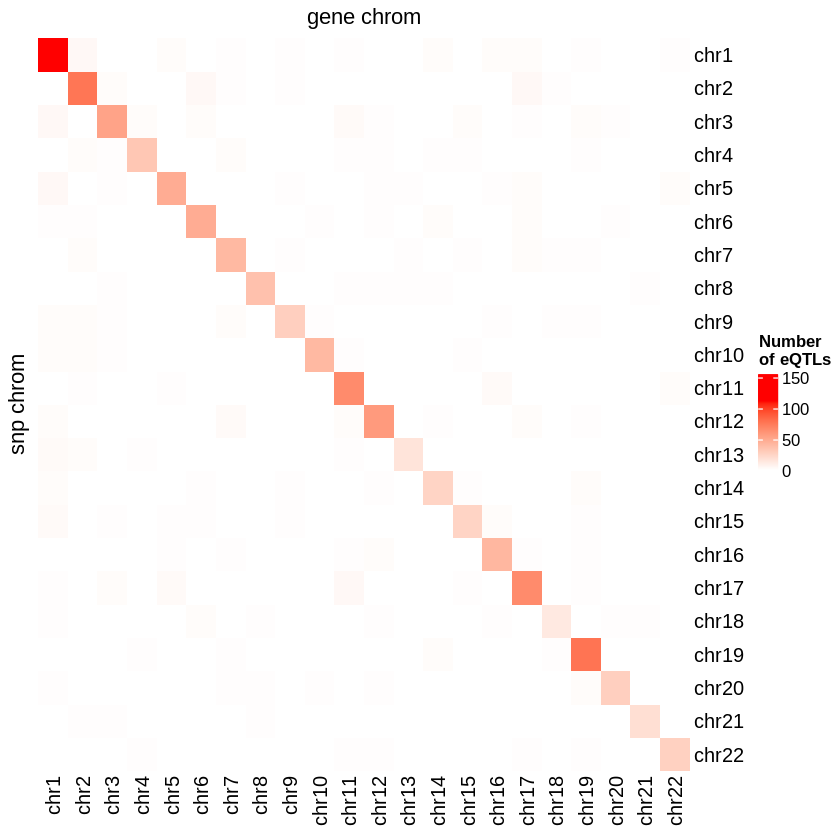

In [11]:
# all results (cis + trans)
col_fun = colorRamp2(c(0, max(mat)), c("white", "red"))
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [12]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"CD4_NC_trans_cis_heatmap_pv_5e_8.pdf"), width=10, height=10)
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2

In [13]:
# trans only (different chromosome and or not within 2Mb of gene)
# df_combine_trans_only = df_combine[df_combine$cis.trans == "potential_novel"]
df_combine$cis.trans.2mb = "trans"
df_combine$snp_Chr = as.character(df_combine$snp_Chr)
df_combine[df_combine$gene_chr == df_combine$snp_Chr & df_combine$snp_Start >= df_combine$window_start & df_combine$snp_Start <= df_combine$window_end, "cis.trans.2mb"] = "cis"
table(df_combine$cis.trans.2mb)
df_combine_trans_only = df_combine[df_combine$cis.trans.2mb == "trans"]


  cis trans 
  948   238 

In [14]:
mat_trans=as.matrix(table(df_combine_trans_only$snp_Chr, df_combine_trans_only$gene_chr))
rownames(mat_trans) = paste0("chr",rownames(mat_trans))
colnames(mat_trans) = paste0("chr",colnames(mat_trans))
mat_trans = mat_trans[paste0("chr",1:22),paste0("chr",1:22)]

In [15]:
max(mat_trans)

[1] 7

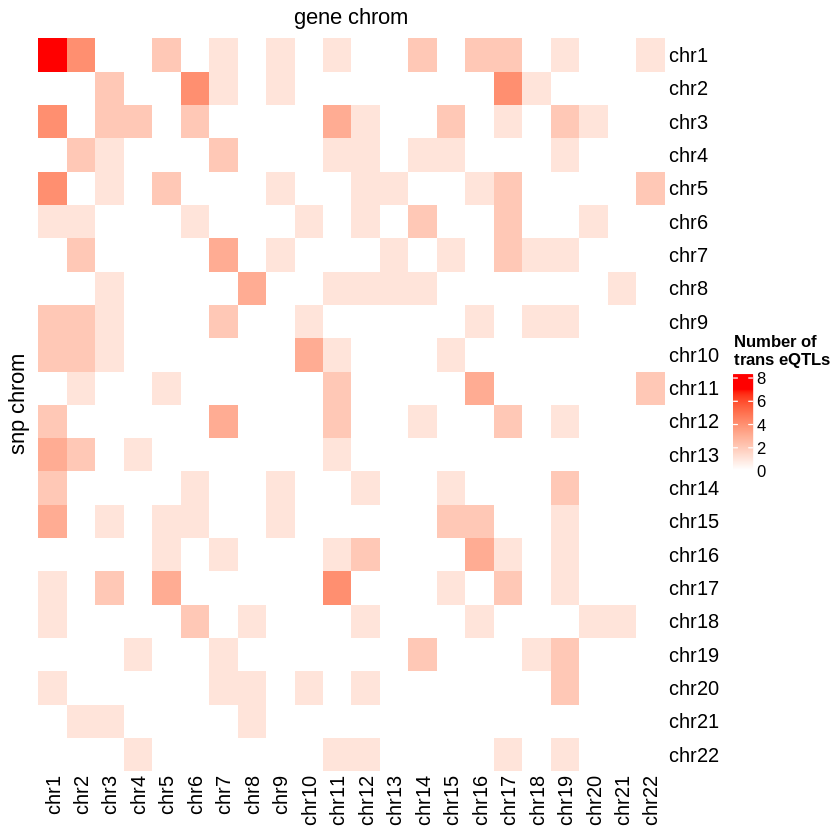

In [16]:
col_fun = colorRamp2(c(0, max(mat_trans)), c("white", "red"))
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [17]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"CD4_NC_trans_only_heatmap_pv_5e_8.pdf"), width=10, height=10)
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2